In [ ]:
import pandas as pd
import numpy as np 
import nltk, re, string, random, time, warnings, sys
sys.path.append('/content/drive/MyDrive/COMP-5800-YDE-Yidong-Devansh-Final-Project/FeatureExtractionCode')
import datavisualization as dv
from nltk.tokenize import word_tokenize
from collections import Counter, OrderedDict

#ignore the warnings
warnings.filterwarnings("ignore")

In [ ]:
#run this one time to extract the conceptual numberbatch embeddings text file
#extract the .gz conceptual numberbatch embedding 
#!gzip -d /content/drive/MyDrive/COMP-5800-YDE-Yidong-Devansh-Final-Project/EmbeddingFile/numberbatch-19.08.txt.gz

In [ ]:
#decorator function for calculating the total time reqired to execute various function
def calc_time(func):
  def inner(*args, **kwargs):
    st = time.time()
    result = func(*args,**kwargs)
    end = time.time()-st
    print("Total time required for function {}: {:.3f} ms".format(func.__name__, end * 1000))
    return result
  return inner

#function to handle error in list or dictionary comprehension
def catch(func, handle=lambda e : e, *args, **kwargs):
    try:
        return func(*args, **kwargs)
    except Exception as e:
        pass

@calc_time
#write data in dictionary to a path as text file
def write_dict(filename,data):
  #open txt file and write data from dictionary to text file
  with open(filename, 'w') as file:
    file.write("{ \n")
    for k,v in data.items():    
      file.write('"%s":"%s", \n' % (k,v))
    file.write("}")

In [ ]:
#function to count frequency of words in the dataset
@calc_time
def count_frequency(df): 
  
  #create a class to create a ordered dictionary
  class OrderedCounter(Counter, OrderedDict):
    pass

  #combine all rows into one single list
  text = ' '.join(df["Content"])
  
  #split sentences into tokens
  text = text.split(' ')
  
  #create a order 
  c = OrderedCounter(text)

  print("Total number of unique words are: {}".format(len(c)))
  
  #dictionary to store the frequency of occurence of words
  #write_dict("/content/drive/MyDrive/COMP-5800-YDE-Yidong-Devansh-Final-Project/EmbeddingFileVocabData/frequency_words.txt",c)

  return c

#function to open word embedding file and return word embedding matrix
@calc_time
def get_embeddings():

  #get word embeddings
  embeddings_index = {}

  #open conceptual numberbatch word embedding file
  with open('/content/drive/MyDrive/COMP-5800-YDE-Yidong-Devansh-Final-Project/EmbeddingFileVocabData/numberbatch-en.txt', encoding='utf-8') as f:        
    for line in f:
      values = line.split(' ')
      word = values[0]
      embedding = np.asarray(values[1:], dtype='float32')
      embeddings_index[word] = embedding

  print('Word embeddings:', len(embeddings_index))

  #write_dict("/content/drive/MyDrive/COMP-5800-YDE-Yidong-Devansh-Final-Project/EmbeddingFileVocabData/word_embedding_index.txt",embeddings_index)
  
  return embeddings_index

#this function is used to build vocabulary and find missing words in word embeddings
@calc_time
def get_vocab(word_counts):

  #mapping vocab to index
  lr=iter([item for item in range(0,len(word_counts))])
  vocab_to_int={k:next(lr) for k,v in word_counts.items()}

  #mapping index to vocab 
  lr=iter([item for item in range(0,len(word_counts))])
  int_to_vocab={next(lr):k for k,v in word_counts.items()}

  #special tokens that will be added to our vocab
  codes = ["<UNK>","<PAD>","<EOS>","<GO>"]

  #add codes to our vocab at the end
  for code in codes:
    vocab_to_int[code] = len(vocab_to_int)
    int_to_vocab[len(int_to_vocab)] = code

  #print usage of words in our model and their percent
  usage_ratio = round(len(vocab_to_int) / len(word_counts),4)*100
  print("Total number of unique words:", len(word_counts))
  print("Number of words we will use:", len(vocab_to_int))
  print("Percent of words we will use: {}%".format(usage_ratio))
  print("length vocab_to_int",len(vocab_to_int))
  print("length int_to_vocab",len(int_to_vocab))

  #store vocab to index mapping in a txt file
  #write_dict("/content/drive/MyDrive/COMP-5800-YDE-Yidong-Devansh-Final-Project/EmbeddingFileVocabData/vocab_to_int.txt",vocab_to_int)
    
  #store index to vocab mapping in a txt file
  #write_dict("/content/drive/MyDrive/COMP-5800-YDE-Yidong-Devansh-Final-Project/EmbeddingFileVocabData/int_to_vocab.txt",int_to_vocab)

  return vocab_to_int, int_to_vocab

In [ ]:
#function to map words with its word embeddings 
#if embeddings not found for the word then map it with a random number in range(-1.0,1.0)
#also if word is not found then break word into character and perform character embedding on the dataset
@calc_time
def word_embedding_index(vocab_to_int,embeddings_index):
  #create empty list to add oov_words
  oov_words = []
  #total number of words 
  nb_words = len(vocab_to_int)
  #embedding dimension
  embedding_dim = 300
  #initialize and empty matrix with zeros
  word_embedding_matrix = np.zeros((nb_words, embedding_dim), dtype=np.float32)
  #if word exists in word embeddings then get the embeddings for particular word
  for word, i in vocab_to_int.items():
    if word in embeddings_index:
      word_embedding_matrix[i] = embeddings_index[word]
    #if word dosent exists in word embedings then find character embedding for individual character and concatenate the individual embeddings 
    elif word not in embeddings_index:
      try:
        a = []
        for j in word:
          a.append(embeddings_index[j])
        op = np.asarray([sum(x) for x in zip(*a)])
        word_embedding_matrix[i] = np.array(op)
      except Exception as e:
        #if still there is an exceptional case then initialize it with a random embedding
        new_embedding = np.array(np.random.uniform(-1.0, 1.0, embedding_dim))
        word_embedding_matrix[i] = new_embedding
        oov_words.append(word)

  #save numpy array 
  np.save('/content/drive/MyDrive/COMP-5800-YDE-Yidong-Devansh-Final-Project/EmbeddingFileVocabData/word_embedding_matrix_weights.npy', word_embedding_matrix)

  print("length of word embedding matrix",len(word_embedding_matrix))

In [ ]:
#append unk and eos tokens 
#if eos is equal to true then append go and eos token at begining and end of the text
#add unknown token for word not found in vocabulary
def convert_to_ints(text,vocab_to_int,eos=False):
  ints = []
  for word in text.split():
    if word in vocab_to_int:
      ints.append(vocab_to_int[word])
    else:
      ints.append(vocab_to_int["<UNK>"])
  if eos:
    ints.insert(0,vocab_to_int["<GO>"])
    ints.insert(len(ints),vocab_to_int["<EOS>"])
  return ints

#count total number of unknown tokens
def count_unk(text):
  unk=0
  eos=0
  #print(text)
  for value in text:
    if 146712 in value:
      unk+=1
  return unk

#count the number of unk tokens to filter
def counts(val):
  c=0
  for i in val:
    try:
      if i==146712:
        c+=1
    except:
      pass
  return c

In [ ]:
#function to generate word frequency dict, vocab dict, embedding dict, generating embedding matrix
#handling out of vocabulary words, word and character embedding
#tokenizing words, converting word to integer, filtering based on length of text required 
#padding all the sentences to the required length and generate a csv file for model training
@calc_time
def main():
  
  #get the final cleaned data
  df=pd.read_csv('/content/drive/MyDrive/COMP-5800-YDE-Yidong-Devansh-Final-Project/DataPreprocessingCode/final_preprocessed_data_yidong_devansh.csv',names=["Content","Label"])

  #hyperparameter for minimum and maximum length of the text
  max_len = 300
  min_len = 0
  unk_len = 1

  #count word frequency and store in a dictionary
  word_counts = count_frequency(df)

  #get the word embedding matrix and store in a dictionary
  embeddings_index = get_embeddings()

  #get our vocabulary to index to word and word to index mapping
  vocab_to_int, int_to_vocab = get_vocab(word_counts)  

  #get embedding for a given word or else perform character embedding 
  word_embedding_index(vocab_to_int,embeddings_index)

  #get the number of missing words 
  missing_words={k:v for k,v in word_counts.items() if k not in embeddings_index.keys()}

  #write missing words on a txt file
  write_dict("/content/drive/MyDrive/COMP-5800-YDE-Yidong-Devansh-Final-Project/EmbeddingFileVocabData/missingwords.txt",int_to_vocab)

  #plot some statistics regarding the data
  dv.plot_some_stats(df,word_counts,missing_words,vocab_to_int)
  
  #length of text should be greater then minimum text requirement
  df = df[df['Content'].apply(lambda x: len(x.split(' ')) > min_len)]

  #reset index
  df.reset_index(drop=True,inplace=True)
  
  #length of text should be less then maximum text requirement
  df = df[df['Content'].apply(lambda x: len(x.split(' ')) <= max_len)]
  
  #reset index
  df.reset_index(drop=True,inplace=True)
 
  #convert words to integers based on their index positions and start and end tokens plus unk token for unknown words 
  df['Content_int'] = df['Content'].apply(lambda x: convert_to_ints(str(x),vocab_to_int,eos=True))
  print("\nAfter mapping Content to integer based on vocab_to_int\n {}".format(df["Content_int"][:5]))
  print("\nTotal number of unk token are: {}".format(count_unk(df["Content_int"])))
  
  #filter out the unknown tokens based on unknown token limit in a sentence
  df = df[df['Content_int'].apply(lambda x: counts(x) <= unk_len)]
  
  #reset index
  df.reset_index(drop=True,inplace=True)

  #save the data to a csv file
  df.to_csv("/content/drive/MyDrive/COMP-5800-YDE-Yidong-Devansh-Final-Project/EmbeddingFileVocabData/Final_data_Y_D.csv",index=False)

Total number of unique words are: 146712
Total time required for function write_dict: 696.734 ms
Total time required for function count_frequency: 12386.894 ms
Word embeddings: 516783
Total time required for function write_dict: 1293575.086 ms
Total time required for function get_embeddings: 1336143.801 ms
Total number of unique words: 146712
Number of words we will use: 146716
Percent of words we will use: 100.0%
length vocab_to_int 146716
length int_to_vocab 146716
Total time required for function write_dict: 436.321 ms
Total time required for function write_dict: 379.471 ms
Total time required for function get_vocab: 1186.891 ms
Total time required for function write_dict: 347.059 ms

Length of the final data: 451709

Some information regarding data
 <bound method DataFrame.info of                                                   Content Label
0       denial of normal the con be asked to comment o...     1
1       just by being able to tweet this insufferable ...     1
2       that


 None

 None

After mapping Content to integer based on vocab_to_int
 0    [146715, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,...
1    [146715, 14, 15, 16, 17, 7, 18, 19, 20, 21, 22...
2    [146715, 28, 29, 30, 26, 31, 32, 7, 5, 33, 28,...
3    [146715, 35, 1, 24, 36, 37, 38, 39, 40, 1, 41,...
4                         [146715, 46, 47, 48, 146714]
Name: Content_int, dtype: object

Total number of unk token are: 0
Total time required for function main: 1392291.237 ms


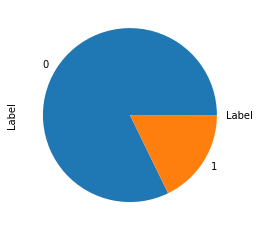

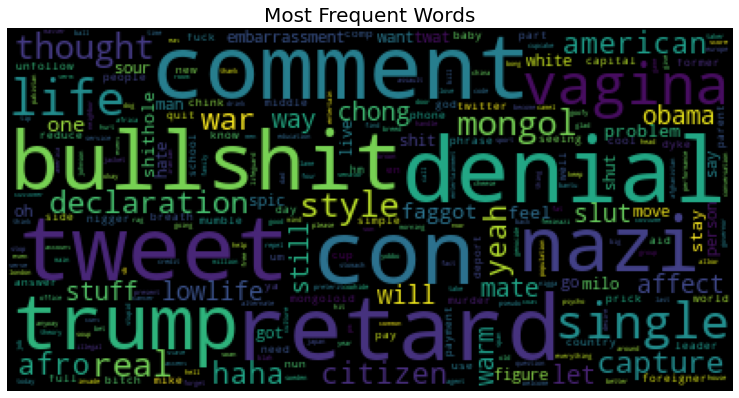

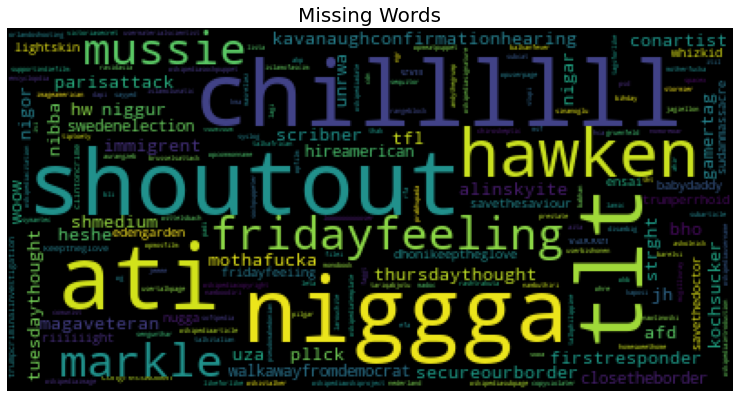

In [ ]:
if __name__:main()